In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

from PIL import Image

In [3]:
from dask.distributed import Client, progress
client = Client()
client

/home/bruno-pacheco/miniconda3/envs/uncertainty/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42521 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42521/status,
Dashboard: http://127.0.0.1:42521/status,Workers: 4
Total threads: 16,Total memory: 31.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40473,Workers: 4
Dashboard: http://127.0.0.1:42521/status,Total threads: 16
Started: Just now,Total memory: 31.29 GiB
Comm: tcp://127.0.0.1:45927,Total threads: 4
Dashboard: http://127.0.0.1:45279/status,Memory: 7.82 GiB
Nanny: tcp://127.0.0.1:39209,


In [4]:
path = '/data/busi_wo_null_train_masks'

masks = [np.array(Image.open(os.path.join(path, file)).resize((256,256))).astype('float32') for file in os.listdir(path)]
masks = np.stack(masks)

Y = masks.reshape(masks.shape[0],-1)
Y = da.from_array(Y, chunks=(Y.shape[0],512))

Y.shape, Y.numblocks

((494, 65536), (1, 128))

In [5]:
np_cov = np.cov(Y.compute()[:,-8*4098:])
da_cov = da.cov(Y[:,-8*4098:])

np.isclose(np_cov, da_cov.compute()).all()

/home/bruno-pacheco/miniconda3/envs/uncertainty/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 123.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/bruno-pacheco/miniconda3/envs/uncertainty/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 62.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


True

In [6]:
cov = da.cov(Y.T)
cov

/home/bruno-pacheco/miniconda3/envs/uncertainty/lib/python3.11/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 128
  intermediate = blockwise(


dask.array<truediv, shape=(65536, 65536), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>

In [7]:
L = da.linalg.cholesky(cov + da.eye(cov.shape[0]) * 1e-3, lower=True)
L

dask.array<cholesky, shape=(65536, 65536), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>

In [8]:
# da.to_npy_stack('./data/interim/BUSI_L_cov/', L)

In [5]:
L = da.from_npy_stack('./data/interim/BUSI_L_cov/')
L

dask.array<from-npy-stack, shape=(65536, 65536), dtype=float64, chunksize=(512, 65536), chunktype=numpy.ndarray>

In [26]:
variance = da.diag(L @ L.T).reshape(*masks.shape[1:]).compute()
variance.shape

/home/bruno-pacheco/miniconda3/envs/uncertainty/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 128
  out = blockwise(


(256, 256)

In [28]:
np.savez('BUSI_variance.npz', variance)

/home/bruno-pacheco/miniconda3/envs/uncertainty/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 128
  out = blockwise(


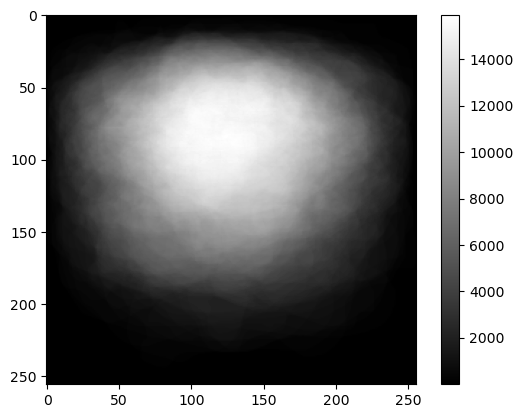

In [15]:
plt.imshow(da.diag(L @ L.T).reshape(*masks.shape[1:]), cmap='gray')
plt.colorbar()
plt.show()

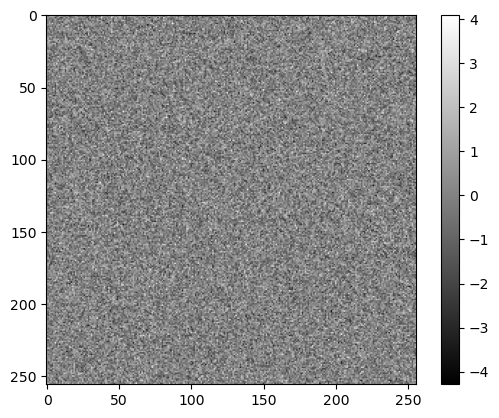

In [18]:
plt.imshow(da.random.normal(0, size=Y.shape[1]).reshape(*masks.shape[1:]), cmap='gray')
plt.colorbar()
plt.show()

/home/bruno-pacheco/miniconda3/envs/uncertainty/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 128
  out = blockwise(


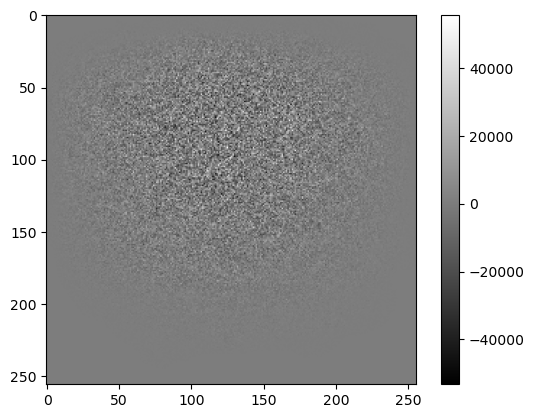

In [23]:
plt.imshow((da.diag(L @ L.T) * da.random.normal(0, size=Y.shape[1])).reshape(*masks.shape[1:]), cmap='gray')
plt.colorbar()
plt.show()

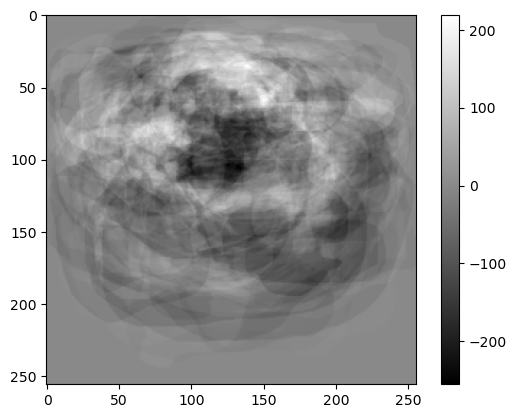

In [24]:
eta = da.random.normal(0, size=Y.shape[1])
eta = L @ eta

plt.imshow(eta.reshape(*masks.shape[1:]), cmap='gray')
plt.colorbar()
plt.show()

In [31]:
eta = da.random.normal(0, size=(2, Y.shape[1]))
eta = eta @ L.T
eta

dask.array<getitem, shape=(2, 65536), dtype=float64, chunksize=(2, 512), chunktype=numpy.ndarray>

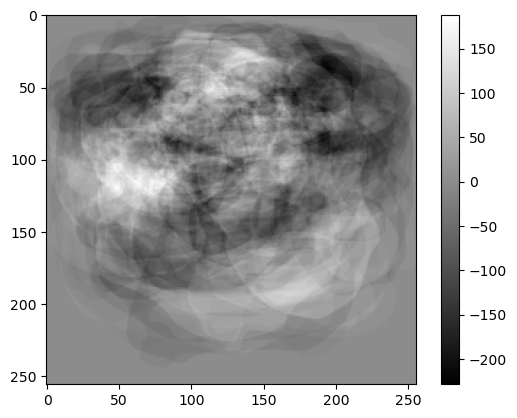

In [32]:
from src.utils import get_noise_with_Lcov

eta = get_noise_with_Lcov('/data/busi_cov_matrix_L/', masks.shape[1:])

plt.imshow(eta, cmap='gray')
plt.colorbar()
plt.show()

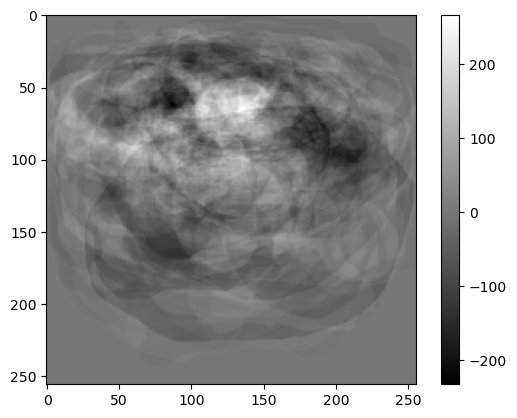

In [33]:
from src.utils import get_noise_with_Lcov

eta = get_noise_with_Lcov('/data/busi_cov_matrix_L/', masks.shape[1:], n=5)

plt.imshow(eta[-1], cmap='gray')
plt.colorbar()
plt.show()